# Calculate depth integrated heat budget from EAC-ROMS daily output in a randomly positioned box in the Tasman Sea

In [1]:
import numpy as np
import xarray as xr
#from dask.diagnostics import ProgressBar
from xgcm import Grid
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

In [2]:
#datapath = '/srv/scratch/z3097808/20year_run/20year_freerun_output_NEWnci/'
#ts = xr.open_mfdataset(datapath + 'outer_avg_014*.nc', chunks={'ocean_time': 10}, combine='by_coords', decode_coords=True)

In [2]:
#load pre-subsetted file (if available), otherwise uncomment the cells above and below this one
ds = xr.open_mfdataset('heat_flux_test_box.nc', chunks={'ocean_time': 10}, combine='by_coords', decode_coords=True)

In [3]:
print('Total Size: %6.2F GB' % (ds.nbytes / 1e9))

Total Size:   0.02 GB


In [4]:

# i = 50    # i = 150         # southward boundary
# ii = 70  # ii = 160         # northward boundary
# j = 130         # j = 90          # westward boundary
# jj = 150         # jj = 100         # eastward boundary
# ds = ts.isel(eta_psi=slice(i,ii-1), eta_rho=slice(i,ii), eta_u=slice(i,ii), eta_v=slice(i,ii-1),
#               xi_psi=slice(j,jj-1), xi_rho=slice(j,jj), xi_u=slice(j,jj-1), xi_v=slice(j,jj))

# print('Total Size: %6.2F GB' % (ds.nbytes / 1e9))

In [5]:
#ds.to_netcdf('heat_flux_test_box.nc')

# Creating a grid object
While xgcm doesn't currently have an implementation for the SGRID convention for ROMS, a workaround consist on renaming eta_u and xi_v dimensions to rho. With this replacement 'psi' points have now a position (eta_v, xi_u). See issue here https://github.com/xgcm/xgcm/issues/108

Here I also test to see if the new XGCM 'metrics' functionality works.

In [6]:
# Including metrics
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

/home/z3526974/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  from ipykernel import kernelapp as app
/home/z3526974/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  app.launch_new_instance()


In [7]:
grid

<xgcm.Grid>
X Axis (not periodic):
  * center   xi_rho --> inner
  * inner    xi_u --> center
Y Axis (not periodic):
  * center   eta_rho --> inner
  * inner    eta_v --> center
Z Axis (not periodic):
  * center   s_rho --> outer
  * outer    s_w --> center

In [8]:
#calculate temperature advection at each gridpoint, strictly should be on U and V points, but I don't think this is a major issue here
ds['T_u'] = grid.interp(ds.u, axis='X', boundary = 'extend')*ds.temp
ds['T_v'] = grid.interp(ds.v, axis='Y', boundary = 'extend')*ds.temp

ds['T_uz'] = (grid.integrate(ds.T_u, 'Z'))/ds.h
ds['T_vz']= (grid.integrate(ds.T_v, 'Z'))/ds.h
ds.T_uz

<xarray.DataArray 'T_uz' (ocean_time: 60, eta_rho: 20, xi_rho: 20)>
dask.array<truediv, shape=(60, 20, 20), dtype=float64, chunksize=(10, 20, 18), chunktype=numpy.ndarray>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(20, 20), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(20, 20), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 1994-01-01T12:00:00 ... 1994-03-01T12:00:00
Dimensions without coordinates: eta_rho, xi_rho

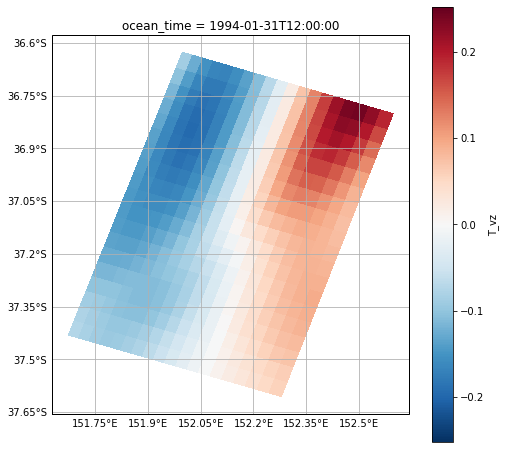

In [9]:
fig = plt.figure(figsize=(8,8))
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
ax = plt.axes(projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
ds.T_vz.sel(ocean_time='1994-01-31T12').plot(ax=ax, transform=ccrs.PlateCarree(), 
                                        x='lon_rho', y='lat_rho', cmap='RdBu_r')
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = gl.ylabels_right = False

In [10]:
#Calculate heat transport, and sanity check that xgcm is calculating areas and volumes right.
Cp = 4181.3
Rho_0 = 1025 
# Calculate volume the romstools way
Volume = ds.h/(ds.pm*ds.pn)        
V0 = Volume.sum(['eta_rho', 'xi_rho'])           
# Calculate volume the xgcm way
V_A = (ds.dA*ds.h).sum(['eta_rho', 'xi_rho'])
# Check that they match
print(V_A[0].values,V0[0].values)

28438518781950.47 28438518781950.47


In [11]:
n = (Cp*Rho_0*(grid.integrate(ds.T_vz, 'X').sel(eta_rho=-1)*-1)).load()
s = (Cp*Rho_0*grid.integrate(ds.T_vz, 'X').sel(eta_rho=0)).load()
w = (Cp*Rho_0*grid.integrate(ds.T_uz, 'Y').sel(xi_rho=0)).load()
e = (Cp*Rho_0*grid.integrate(ds.T_uz, 'Y').sel(xi_rho=-1)*-1).load()
tot_heat_adv = (n+s+e+w) #Total heat advection, which should be in Watts 

Text(0.5, 1.0, 'heat transport into box [W]')

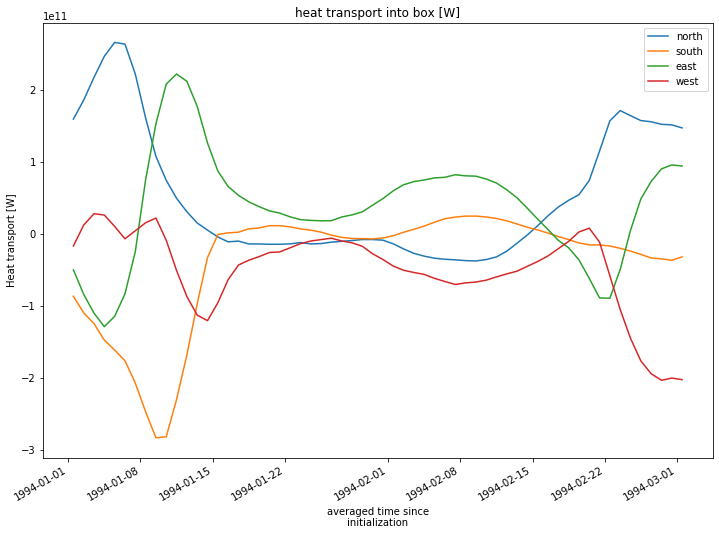

In [12]:
fig = plt.figure(figsize=(12,8))
n.plot(label='north')
s.plot(label='south')
e.plot(label='east')
w.plot(label='west')
plt.legend()
plt.ylabel('Heat transport [W]')
plt.title('heat transport into box [W]')
#plt.savefig('heat_transport.png', dpi=300,bbox_inches='tight')

Text(0.5, 1.0, 'heat transport into box')

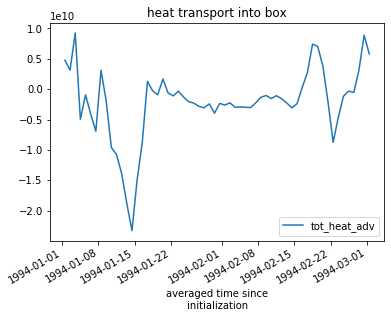

In [13]:
tot_heat_adv.plot(label='tot_heat_adv')
plt.legend()
plt.title('heat transport into box')
#plt.savefig('heat_transport.png', dpi=300,bbox_inches='tight')

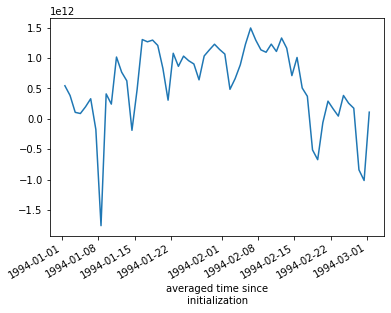

In [14]:
# Surface heat flux 
tot_Q = (grid.integrate(ds.shflux, ['X','Y'])).load() # produces same result as line below - so xgcm works for this
#tot_Q = ds.shflux.sum(dim=['eta_rho','xi_rho'])*2500*5000# W/m^2*m^2 = W can do this more exactly later
tot_Q.plot()

Text(0.5, 1.0, 'total heat transport into box')

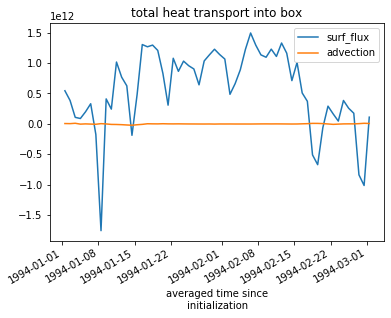

In [15]:
tot_Q.plot(label= 'surf_flux')
tot_heat_adv.plot(label='advection')
plt.legend()
plt.title('total heat transport into box')

Text(0.5, 1.0, 'total energy input from Qnet & advection [J]')

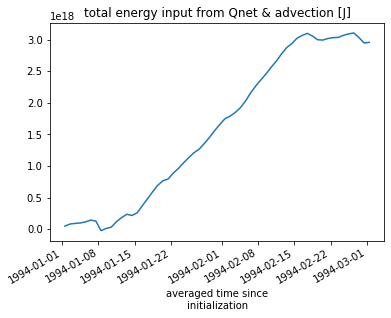

In [16]:
calc_tendency = (tot_heat_adv + tot_Q) # Watts + Watts
ADV_Q = (calc_tendency*86400).cumsum() # Watts is J/s, so we multiply by no. of seconds in a day to get a daily value in J.
ADV_Q.plot()
plt.title('total energy input from Qnet & advection [J]')

In [17]:
# Total heat in joules put into system by advection and atmospheric cooling
ADV_Q.sum().values

array(9.58785257e+19)

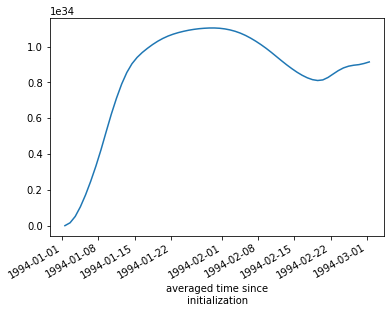

In [18]:
# Think that my mess up is in the below.
temperature_tendency = ((grid.integrate((ds.temp-ds.temp[0,:,:,:]), ['X','Y','Z'])*Rho_0*Cp*V0.mean())) # K*kg/m^3*J/kgK*m^3 = J
temperature_tendency.cumsum().plot()